In [246]:
import numpy as np
import pandas as pd
from pandas.compat import StringIO
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pylab 

import csv
import collections
import dateutil.parser as date
import jinja2
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image

sys.path.append('/scripts/')
import analysis as an

region = 'united_states'

## Curie Data

In [2]:
df = pd.read_csv('SNF_nuclide_2020_07_01.dat',sep='\s+',index_col = False)

In [3]:
date_isotope_mass = df[['discharge_date','name','total_mass_g']]
date_mass = df[['discharge_date','total_mass_g']]

In [176]:
spent_fuel_mass = date_mass.groupby('discharge_date').sum()
spent_fuel_mass_cum = spent_fuel_mass.cumsum()
spent_fuel_mass_cum['total_mass_g'] = spent_fuel_mass_cum['total_mass_g'].apply(lambda x: x*0.000001)
spent_fuel_mass_cum = spent_fuel_mass_cum.rename(columns = {'total_mass_g':'total_mass_MTHM_CURIE'})
spent_fuel_mass_cum.index.names = ['discharge_date']

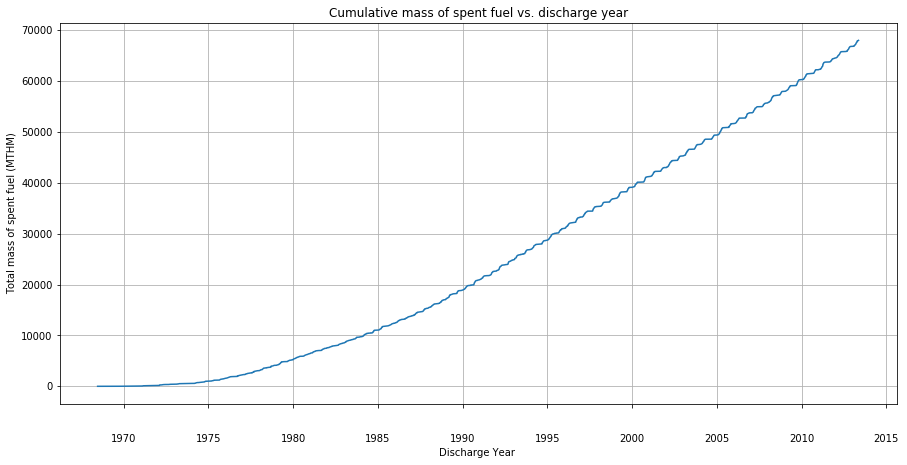

In [193]:
index = spent_fuel_mass_cum.index.values
data = spent_fuel_mass_cum.values
dts = pd.to_datetime(index)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data)
ax.grid()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ')
ax.set_ylabel('Total mass of spent fuel (MTHM)')
ax.set_title('Cumulative mass of spent fuel vs. discharge year')
plt.savefig('figures/cumulative_mass_spent_fuel.png', dpi=300)

** Cumulative CURIE spent fuel isotope mass vs discharge time ** 

In [264]:
CURIE_isotope = date_isotope_mass.pivot_table(index='discharge_date',columns='name',aggfunc=sum)
CURIE_isotope_cum = CURIE_isotope.cumsum()


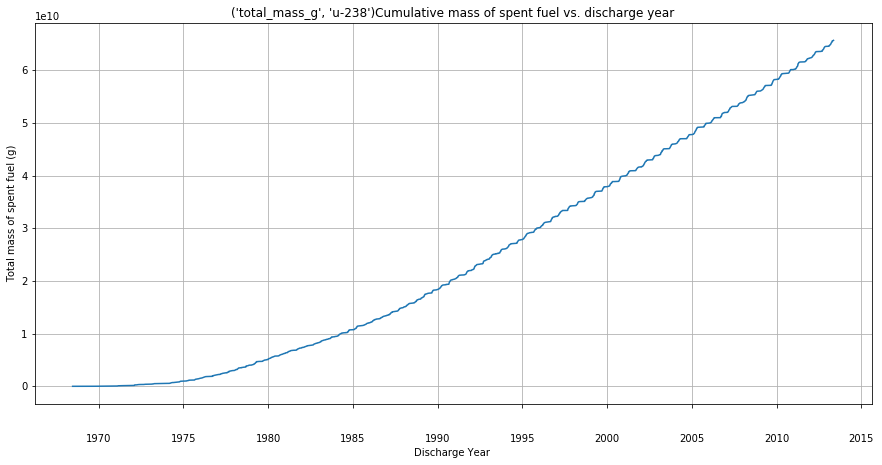

In [260]:
index = CURIE_isotope_cum.index.values
column = list(CURIE_isotope_cum.columns.values)
data = CURIE_isotope_cum.values
dts = pd.to_datetime(index)
col_no = -1

for col in column:
    col_no = col_no + 1 
    if 'u-238' in col: # Insert your chosen isotope here to get its plot 
        column_single = col_no

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data[:,(column_single)])
ax.grid()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ')
ax.set_ylabel('Total mass of spent fuel (g)')
ax.set_title(str(column[column_single]) + 'Cumulative mass of spent fuel vs. discharge year')
plt.savefig('figures/cumulative_mass_spent_fuel.png', dpi=300)

## CYCLUS Data

In [10]:
def get_cursor(file_name):
    """ Connects and returns a cursor to an sqlite output file

    Parameters
    ----------
    file_name: str
        name of the sqlite file

    Returns
    -------
    sqlite cursor
    """
    con = lite.connect(file_name)
    con.row_factory = lite.Row
    return con.cursor()


cursor = get_cursor('cyclus/united_states.sqlite')

In [11]:
def get_timesteps(cur):
    """ Returns simulation start year, month, duration and
    timesteps (in numpy linspace).

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    init_year: int
        start year of simulation
    init_month: int
        start month of simulation
    duration: int
        duration of simulation
    timestep: list
        linspace up to duration
    """
    info = cur.execute('SELECT initialyear, initialmonth, '
                       'duration FROM info').fetchone()
    init_year = info['initialyear']
    init_month = info['initialmonth']
    duration = info['duration']
    timestep = np.linspace(0, duration - 1, num=duration)

    return init_year, init_month, duration, timestep

ini_yr, ini_month, dur, timestep = get_timesteps(cursor)

/Users/gwenchee/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


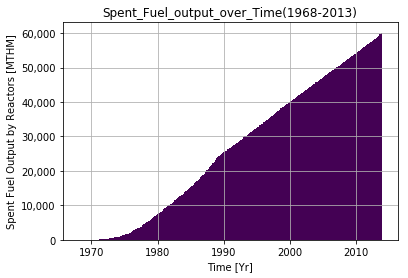

In [23]:
start_year = 1968
end_year = 2014
start_index = (start_year - 1965) * 12
end_index = (end_year - 1965) * 12
dura = end_year - start_year
init_yr, init_month, duration, timestep = an.get_timesteps(cursor)

def spent_fuel_produced(cur): 
    """ Find timeseries of mass of spent fuel output by reactors 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    timeseries list of spent fuel output by reactors
    """

    init_yr, init_month, duration, timestep = get_timesteps(cursor)
    spent_fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                             'INNER JOIN resources '
                             'ON transactions.resourceid = resources.resourceid '
                             'WHERE Commodity = "spent_uox" '
                             'GROUP BY time ').fetchall()
    return an.get_timeseries_cum(spent_fuel,duration,True)

timestep_range = timestep[start_index: end_index]
full_range = spent_fuel_produced(cursor)
generated_range = full_range[start_index: end_index]

img_out = 'figures/'
pathlib.Path(img_out).mkdir(parents=True, exist_ok=True)
name = 'Spent_Fuel_output_over_Time(1968-2013)'
output_reactor = {'Spent_Fuel_Output': generated_range}
an.stacked_bar_chart(output_reactor, timestep_range,
                     'Time [Yr]', 'Spent Fuel Output by Reactors [MTHM]',
                     name, img_out + name, init_yr)
    
Image(filename=img_out + name + '.png')

In [247]:
cyclus_dates = pd.date_range(start='1/1/1968', periods=552, freq='M')
cyclus_data = pd.DataFrame({'discharge_date':cyclus_dates, 'total_mass_MTHM_cyclus': generated_range})
cyclus_data = cyclus_data.set_index('discharge_date')
cyclus_data.index.names = ['discharge_date']

** Cumulative CYCLUS spent fuel isotope mass vs discharge time ** 

/Users/gwenchee/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1717: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


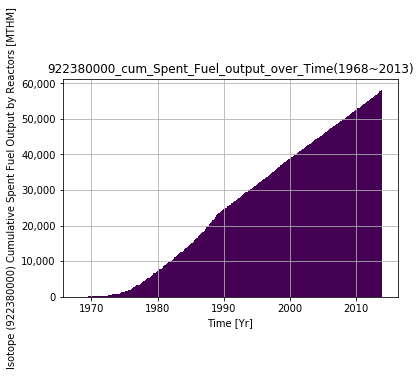

In [261]:
start_year = 1968
end_year = 2014
start_index = (start_year - 1965) * 12
end_index = (end_year - 1965) * 12
dura = end_year - start_year
init_yr, init_month, duration, timestep = an.get_timesteps(cursor)

def isotope_list(cur):
    """ Find list of isotopes present in spent fuel output by reactor 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    list of isotopes in spent fuel output by reactors
    """   
    
    init_yr, init_month, duration, timestep = an.get_timesteps(cursor)
    isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                           'INNER JOIN resources '
                           'ON transactions.resourceid = resources.resourceid '
                           'LEFT OUTER JOIN compositions '
                           'ON resources.qualid = compositions.qualid '
                           'WHERE Commodity = "spent_uox" AND nucid = 922380000 ' # change isotope no. here
                           ' GROUP BY time ').fetchall()
    return an.get_timeseries_cum(isotopes,duration,True)

timestep_range = timestep[start_index: end_index]
full_range = isotope_list(cursor)
generated_range = full_range[start_index: end_index]

img_out = 'figures/'
pathlib.Path(img_out).mkdir(parents=True, exist_ok=True)
name = '922380000_cum_Spent_Fuel_output_over_Time(1968~2013)' # change isotope no. here
isotope_output_reactor = {'Isotopes_Spent_Fuel_Output': generated_range}
an.stacked_bar_chart(isotope_output_reactor, timestep_range,
                     'Time [Yr]', 'Isotope (922380000) Cumulative Spent Fuel Output by Reactors [MTHM]', # change isotope no. here
                     name, img_out + name, 1965) 
    
Image(filename=img_out + name + '.png')

## Cumulative Spent Fuel (1968 - 2013) for CURIE and Cyclus on the same plot 

In [248]:
combined_data = spent_fuel_mass_cum.join(cyclus_data, how='outer')

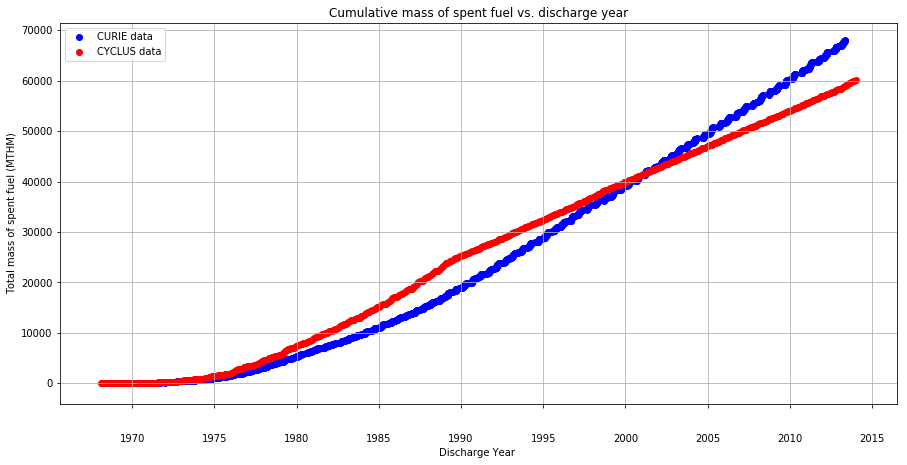

In [245]:
index = combined_data.index.values
data = combined_data.values
dts = pd.to_datetime(index)

fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(dts, data[:,0], color = 'b', label='CURIE data')
ax.scatter(dts, data[:,1], color = 'r', label='CYCLUS data')
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ')
ax.set_ylabel('Total mass of spent fuel (MTHM)')
ax.set_title('Cumulative mass of spent fuel vs. discharge year')
plt.savefig('figures/cumulative_mass_spent_fuel.png', dpi=300)

## Cumulative Major Isotopes Spent Fuel (1968 - 2013) for CURIE and Cyclus on the same plot ** 

The isotopes that contribute the most to the total mass of the spent fuel in order of significance are: 
1. U-238 
2. U-235
3. Pu-239
4. U-236
5. Pu-240

** U-238 ** 